In [27]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils import data
import os
import matplotlib.pyplot as plt


In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [7]:
full_data = datasets.ImageFolder(root=('data/train'))
full_data

Dataset ImageFolder
    Number of datapoints: 1494
    Root location: data/train

In [14]:
train_size = int(0.8 * len(full_data))
val_size = len(full_data) - train_size

In [15]:
train_size + val_size == len(full_data)

True

In [16]:
train_subset, val_subset = data.random_split(full_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

In [17]:
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_transform

In [21]:
num_workers = os.cpu_count()
num_workers

10

In [25]:
train_loader = data.DataLoader(train_subset, batch_size=64, num_workers=num_workers, shuffle=True)
test_loader = data.DataLoader(val_subset, batch_size=64, num_workers=num_workers, shuffle=False)

/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/ai/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `t

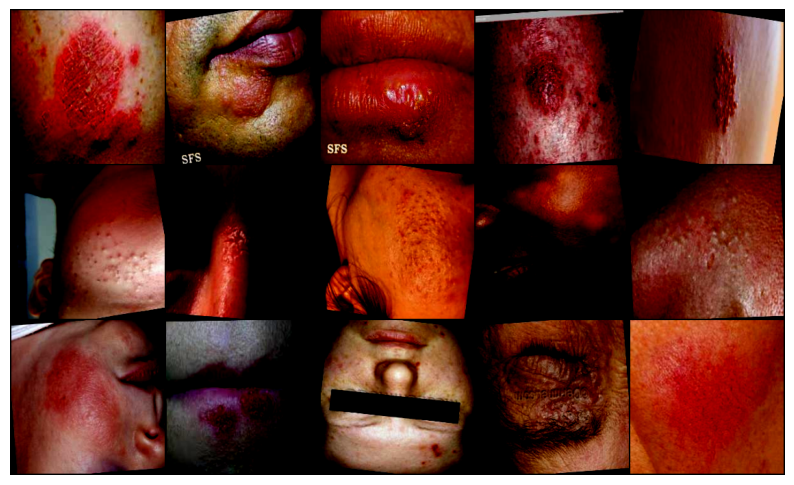

In [28]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(10, 8))
plt.imshow(make_grid(images[:15], nrow=5).permute(1, 2, 0))
plt.axis("off")
plt.show()

In [29]:
device = 'mps' if torch.mps.is_available() else 'cpu'
device

'mps'

In [30]:
class VGGArchitecture(nn.Module):
    def __init__(self, input, hidden, output):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden, out_features=output)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        print(x.shape)
        x = self.conv_block_2(x)
        print(x.shape)
        x = self.classifier(x)
        return x

In [31]:
num_classes = len(full_data.classes)
num_classes

5

In [32]:
model_0 = VGGArchitecture(input=3, hidden=64, output=num_classes).to(device)
model_0

VGGArchitecture(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=5, bias=True)
  )
)